<a href="https://colab.research.google.com/github/Kalazclint/River_gage_height_forecasting/blob/main/Streamflow_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### This notebook is used to predict gage height of the rivers using the following models: CNN, LSTM, GRU, CONV_BIGRU, CNN_LSTM.

In [ ]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, RepeatVector, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Reshape, GRU, LeakyReLU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

##### Defining each model

In [ ]:
def train_model(trainX, trainY, valX, valY, testX, testY, epochs, batch_size):

  # cnn model with 1D layers
  # model = Sequential([
  #                     Conv1D(filters=64, kernel_size=5, input_shape=(96, 4)),
  #                     MaxPooling1D(pool_size=2),
  #                     Flatten(),
  #                     Dense((96*4), activation='relu'),
  #                     Reshape((96,4))
  # ])

  # gru model
  # model = Sequential([
  #                     GRU(units=50, return_sequences=True, input_shape=(96,4)),
  #                     Dropout(0.2),
  #                     GRU(50),
  #                     Dense((96*4)),
  #                     Reshape((96,4))
  # ])

  # cnn lstm model
  # model = Sequential([
  #                     Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=(96, 4)),
  #                     MaxPooling1D(pool_size=2, strides=1, padding="valid"),
  #                     LSTM(128, return_sequences=True),
  #                     Flatten(),
  #                     Dropout(0.2),
  #                     Dense(96*4),
  #                     Reshape((96,4))
  # ])


  # convbigru
  model = Sequential([
                      Conv1D(filters=128, kernel_size=11, input_shape=(96, 4)),
                      LeakyReLU(alpha=0.1),
                      Conv1D(filters=64, kernel_size=11),
                      LeakyReLU(alpha=0.1),
                      Bidirectional(GRU(units=50)),
                      Dropout(0.2),
                      Dense(96*4),
                      Reshape((96, 4)),
  ])

  # lstm model
  # model = Sequential([
  #     LSTM(192, input_shape=(96, 4)),
  #     Flatten(),
  #     Dense(128, activation="relu"),
  #     Dropout(0.2),
  #     Dense(96*4),
  #     Reshape((96, 4))
  # ])

  model.compile('nadam', loss='mse', metrics=["mae", "mape"])
  print(model.summary())
  callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
  ]
  # epochs = 20
  history = model.fit(
    trainX,
    trainY,
    epochs=epochs,
    batch_size=256,
    validation_data=(valX, valY),
    callbacks=callbacks,
  )
  model.save("train_model.h5")

  # plot the model accuracy
  # plt.plot(history.history['accuracy'])
  # plt.plot(history.history['val_accuracy'])
  # plt.title('model accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'val'], loc='upper left')
  # plt.show()

  # plot model loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # evaluate model with splitted test data
  score = model.evaluate(testX, testY)
  print(f"Accuracy on test data: {score}")
  return model

##### This function is used to split the dataset into train, test and validation. 90% data = training data, 10% = testing data, 20% out of training data = validation data.

In [ ]:
def split_df(df, split_size=0.1):
  test_portion = int(0.1 * len(df))
  test_df = df[-test_portion:]
  train = df[:-test_portion]
  val_portion = int(0.2 * len(df))
  val_df = train[-val_portion:]
  train_df = train[:-val_portion]
  print(f"number of data in: train = {len(train_df)}, val = {len(val_df)}, test = {len(test_df)}")
  return train_df, val_df, test_df

##### This function creates the dataset in the format required for training the model: lookback and prediction is done for 24 hr (96 timeslots as data contains each 15 mins values)

For training, we lookbacks for 24hr data, and predicts next 24 hr of values for all four rivers.

Since every data is 15 mins, so for 1 hour = 4  (15 mins data), ie for 24 hr = 24 * 4 = 96 data rows.

For training, we create a dataset like below:

a. Input (0 - 95) -> output (96 - 192), input (1- 96) -> output (97 - 193) and so on.

b. Input shape: (96, 4), output shape: (96, 4) where 96 = 24 hour results and 4 = four rivers in the comite network.


In [ ]:
def create_dataset(df, horizon=96, lookback = 96):
  X = []
  Y = []

  horizon = 96
  lookback = 96

  for i in range(lookback, len(df) - horizon + 1):
    # for X - (96, 4), Y - (96, 4),
    X.append(df[i - lookback:i, 0:df.shape[1]])
    Y.append(df[i:i+horizon, 0:df.shape[1]])

  X, Y = np.array(X), np.array(Y)
  return X, Y

In [ ]:
def prepare_dataset(df, column_list, return_scaler=False):
  x, y = create_dataset(df)
  print(f"shape of x: {x.shape}, y: {y.shape}")
  return x, y

##### Reading the dataset and training the model

In [ ]:
# taking required columns only
df = pd.read_csv('dataset_2015_2020.csv')
cols = list(df)[1:5]
prep_df = df[cols].astype(float)
scaler = StandardScaler()
norm_df = scaler.fit_transform(prep_df)
train_df, val_df, test_df = split_df(norm_df)

trainX, trainY = prepare_dataset(train_df, cols)
valX, valY = prepare_dataset(val_df, cols)
testX, testY = prepare_dataset(test_df, cols)
model = train_model(trainX, trainY, valX, valY, testX, testY, epochs=5, batch_size=512)

number of data in: train = 147302, val = 42086, test = 21043
shape of x: (147111, 96, 4), y: (147111, 96, 4)
shape of x: (41895, 96, 4), y: (41895, 96, 4)
shape of x: (20852, 96, 4), y: (20852, 96, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 86, 128)           5760      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 86, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 64)            90176     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 76, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 100)              34800     
 l)                                                  

##### The following section does the prediction for any new dataset.

In [ ]:
# transform the values into original values
def inverse_transform(data, scaler):
  result = []
  for d in data:
    result.append(np.asarray(scaler.inverse_transform(d)))
  print(f"orignial datashape: {data.shape}, descaled data shape: {np.asarray(result).shape}")
  return np.asarray(result)

In [ ]:
a = model.predict(testX[:96])
print(f"predicted value: {a[0][0]}, original value: {testY[0][0]}")

predicted value: [-0.54107124 -0.14386043 -0.17866185  0.78109026], original value: [-0.55305441 -0.20275617 -0.26470254  0.6074701 ]


##### Prediction using new dataset

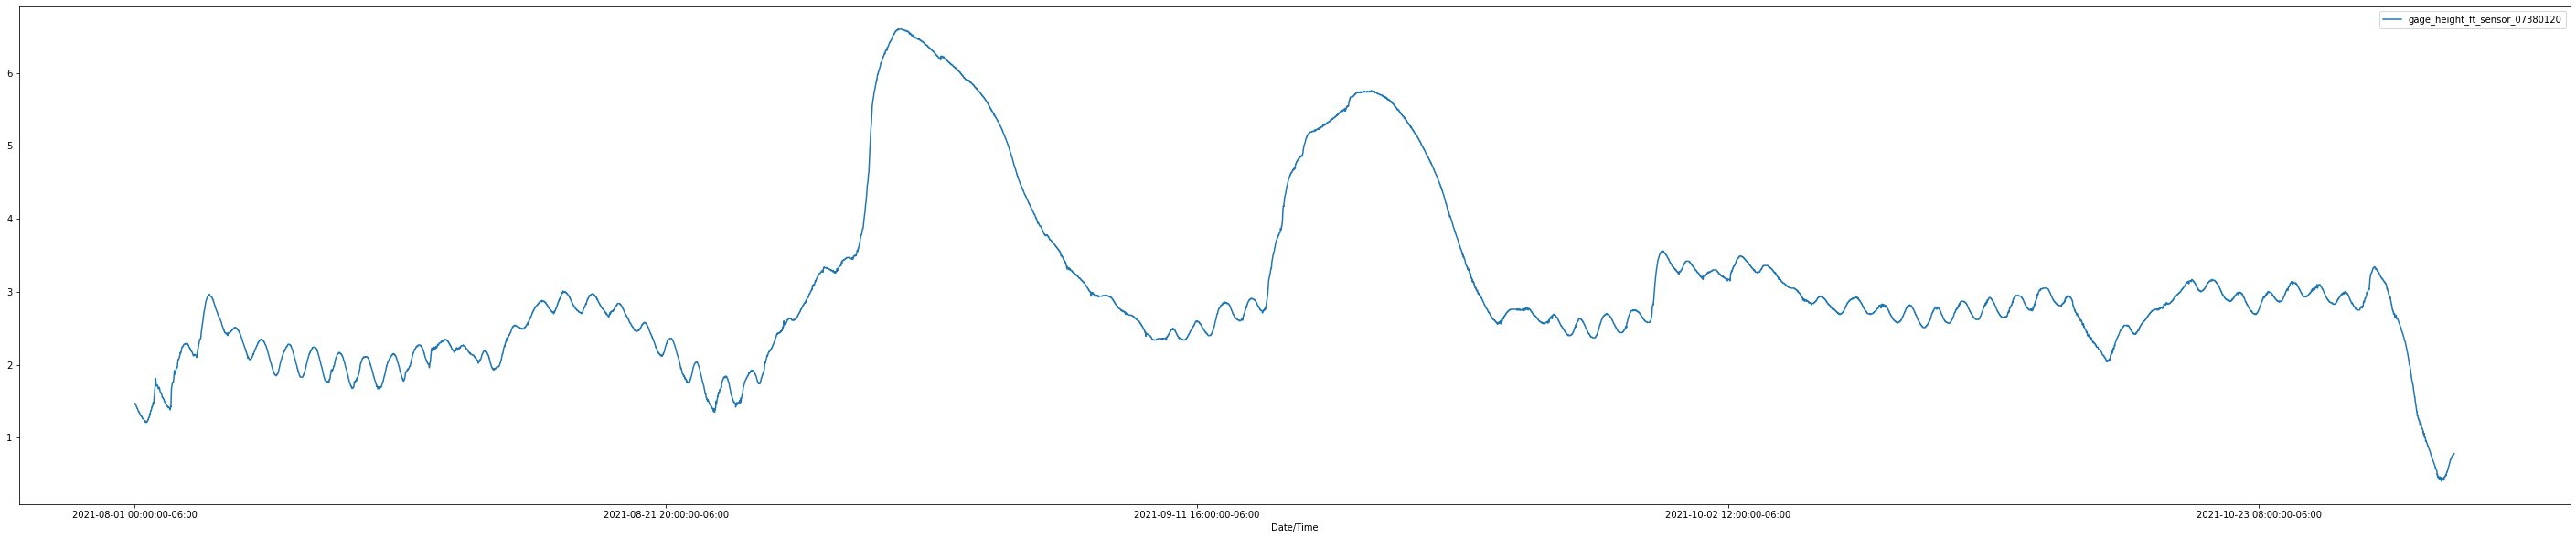

In [ ]:
# prediction for dataset_test
# read data
testdata_df = pd.read_csv("dataset_test4.csv")
testdata_df.plot(x="Date/Time", y=["gage_height_ft_sensor_07380120"], figsize=(50, 10))

In [ ]:
cols = list(testdata_df)[1:5]
testdata_df = testdata_df[cols].astype(float)
testdata_df.head(), testdata_df.shape

(   gage_height_ft_sensor_07377600  gage_height_ft_sensor_07377760  \
 0                           13.51                            2.77   
 1                           13.50                            2.71   
 2                           13.50                            2.65   
 3                           13.50                            2.62   
 4                           13.50                            2.59   
 
    gage_height_ft_sensor_07378050  gage_height_ft_sensor_07380120  
 0                           21.06                            1.47  
 1                           21.20                            1.47  
 2                           21.33                            1.46  
 3                           21.44                            1.45  
 4                           21.54                            1.45  ,
 (8736, 4))

In [ ]:
tscaler = StandardScaler()
testdata = tscaler.fit_transform(testdata_df)

In [ ]:
# making test dataset ready
def create_testdata(df, lookback = 96):
  X = []
  Y = []

  horizon = 96
  lookback = 96
  steps=lookback
  for i in range(0, len(df)-steps, steps):
    X.append(df[i:i+steps])
    Y.append(df[i+steps:i+steps+horizon])

  X, Y = np.array(X), np.array(Y)
  return X, Y

In [ ]:
new_testX, new_testY = create_testdata(testdata)
print(new_testX.shape)
new_predY = model.predict(new_testX)
results = []
orig_data_list = []
for i in range(new_predY.shape[0]):
  orig_data = tscaler.inverse_transform(new_testY[i])
  pred_data = tscaler.inverse_transform(new_predY[i])
  results.append(pred_data)
  orig_data_list.append(orig_data)

flat_list = [item for sublist in results for item in sublist]
d = pd.DataFrame(flat_list, columns=["pred_1", "pred_2", "pred_3", "pred_4"])
d.to_csv("predicted_testdata.csv")

flat_list_orig = [item for sublist in orig_data_list for item in sublist]
df_o = pd.DataFrame(flat_list_orig, columns=["orig_1", "orig_2", "orig_3", "orig_4"])
df_o.to_csv("original_testdata.csv")

(90, 96, 4)


##### Compute NSE and RMSE score

In [ ]:
# splitting dataset in sections for hourly metric score calculation
def split_list(l, steps=4):
  res = []
  for i in range(0, len(l), steps):
    res.append(l[i:i+steps])
  return res

In [ ]:
def calculate_nse(d1, d2):
  mean_val = np.mean(d1)
  numerator = np.sum([(m-n)**2 for m, n in zip(d1, d2)])
  denominator = np.sum([(m-mean_val)**2 for m in d1])
  nse = 1 - (numerator/denominator)
  return nse

def calculate_rmse(col_orig, col_pred):
  diff = [(m-n)**2 for m, n in zip(list(col_orig), list(col_pred))]
  rmse = np.sqrt(np.mean(diff))
  return rmse

##### Data split in each with 4 values/ hourly score calculation

In [ ]:
d1 = df_o['orig_4'].values
d2 = d["pred_4"].values

In [ ]:
calculate_nse(d1, d2), calculate_rmse(d1, d2)

(0.924469901101404, 0.318139714269927)

In [ ]:
d1_l = split_list(d1)
d2_l = split_list(d2)
# print(d1_l, d2_l)
rmse_all = []
count_all =[]
for count, (i, j) in enumerate(zip(d1_l, d2_l)):
  rmse = calculate_rmse(i,j)
  rmse_all.append(rmse)
  count_all.append(count+1)

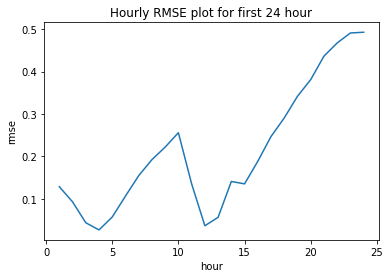

In [ ]:
# plot
plt.plot(count_all[:24], rmse_all[:24])
plt.xlabel('hour')
plt.ylabel('rmse')
plt.title('Hourly RMSE plot for first 24 hour')
plt.show()

#### There are already created models training in these dataset. The following sets of codes can be used to load the model, make predictions and create final csv to compute metrics with all the predictions from different models.


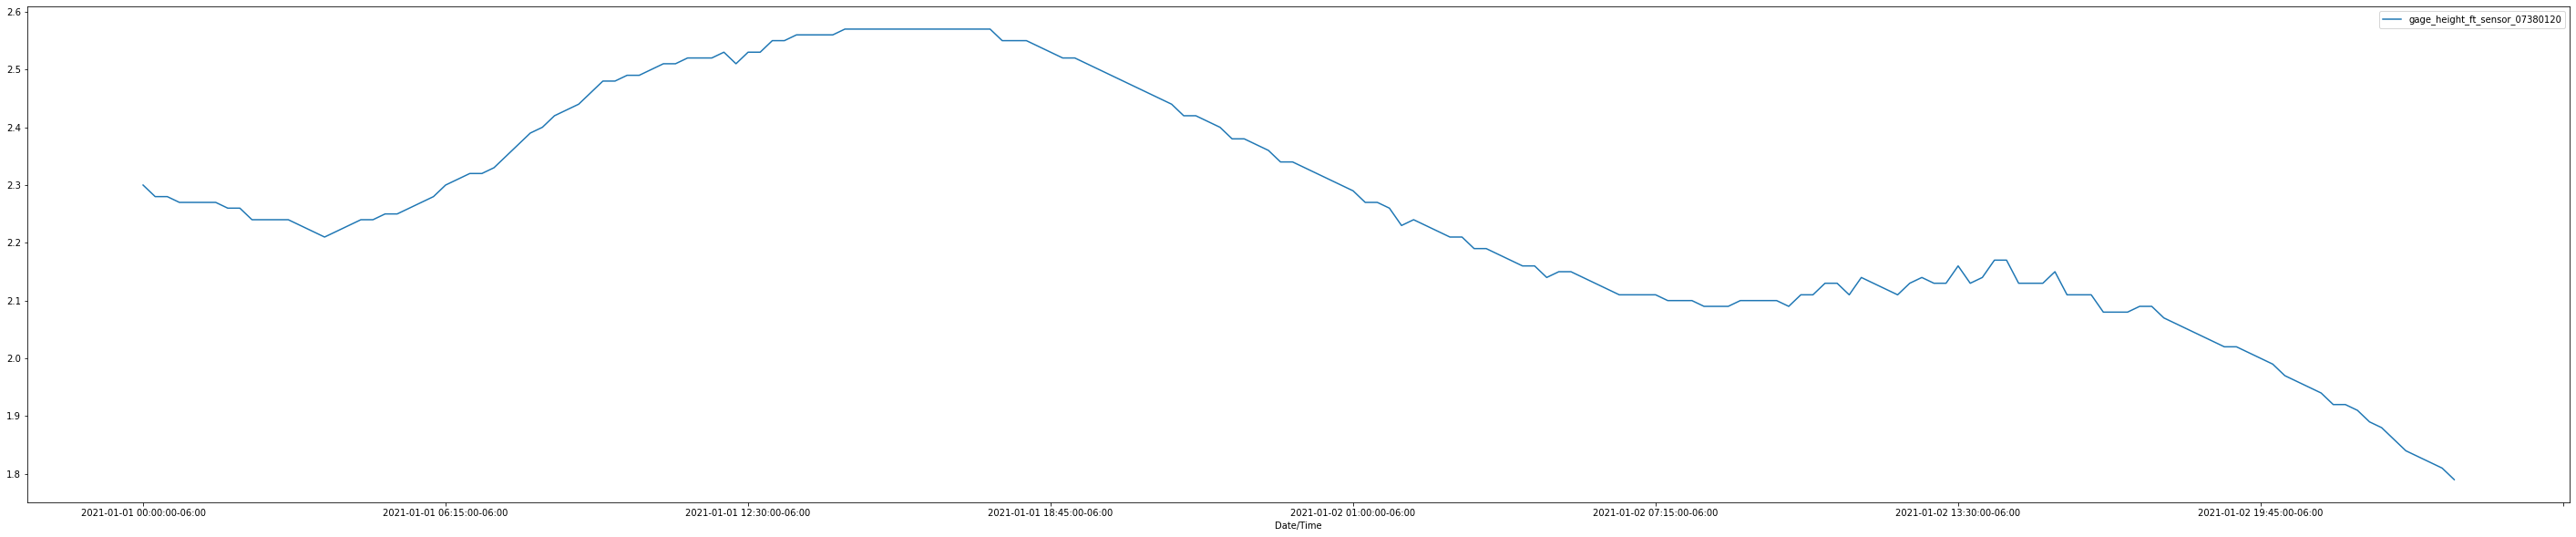

In [ ]:
# read test data
df1= pd.read_csv("dataset_2021_test.csv")
df1.plot(x="Date/Time", y=["gage_height_ft_sensor_07380120"], figsize=(50, 10))
cols = list(df)[1:5]
prep_df = df[cols].astype(float)
scaler = StandardScaler()
norm_df = scaler.fit_transform(prep_df)

# taking only first 24 hour to predict next 24 hour
ip_data = np.array([norm_df[:96]])

# load the model
model = load_model("biconvgru_ep25.h5")

pred_data = model.predict(ip_data)

In [ ]:
def inverse_transform(data, scaler):
  result = []
  for d in data:
    result.append(np.asarray(scaler.inverse_transform(d)))
  print(f"orignial datashape: {data.shape}, descaled data shape: {np.asarray(result).shape}")
  return np.asarray(result)

pred_results = inverse_transform(pred_data, scaler)
result_df = pd.DataFrame(pred_results[0], columns=["1", "2", "3","4"])

# taking 4th column because we are checking the prediction for 4th river
final_df = pd.DataFrame(result_df["4"].values, columns=["convbigru_ep25"])

orignial datashape: (1, 96, 4), descaled data shape: (1, 96, 4)


##### Read and plot the prediction from different models

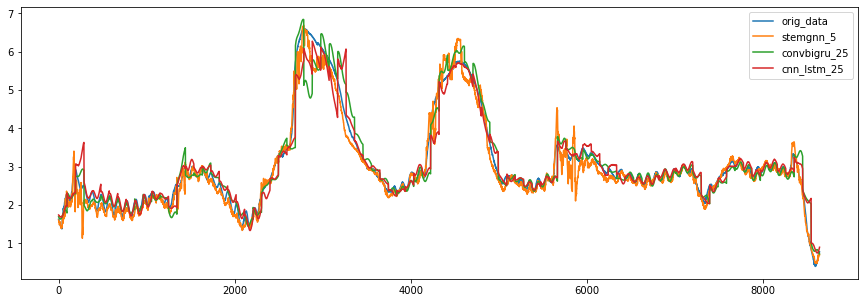

In [ ]:
new_df = pd.read_csv("all_models_test4.csv")
new_df[["orig_data", "stemgnn_5", "convbigru_25", "cnn_lstm_25"]].plot(figsize=(15, 5))